## <center> <제주도에서 사업을 한다면 어디가 딱 좋을까?> </center>
<div>
<img src="img/jeju_ppt/ppt.jpg", width='700'/></div>

### 개요

#### 1. 주제 선정 목적
  - 제주도 소비/결제 데이터 및 지역별 업종 분석
  - EDA를 통한 요소별 상관관계 분석 및 인사이트 도출
  
#### 2. 데이터셋 및 API
   - ① 제주도 업종별 매출 데이터
      - 출처: Dacon "공간정보 탐색적 데이터 분석 경진대회" 
        (https://dacon.io/competitions/official/235682/data/)
      - 목적: 지역별/시간대별 상세 업종 결제액 분석
   - ② 제주도 금융 생활 데이터 
      - 출처: Dacon "KCB 금융스타일 시각화 경진대회"
        (https://dacon.io/competitions/official/82407/overview/description/) 
      - 목적: 직업, 소득, 연령 등 요소별 상관관계 분석
   - ③ 제주도 내국인 관광객 지역, 업종, 성별, 연령대별 카드 이용 데이터 API 
      - 출처: 제주데이터랩 (https://www.jejudatahub.net/data/view/data/597)
   - ④ 카카오 지도 API
      - 출처: kakao developers (https://developers.kakao.com/product/map)
      - 목적: pyproj 활용, ITRF2000 기준 좌표계를 경도/위도 기준값으로 변환
   - ⑤ 제주도 호텔 데이터 크롤링
      - 출처: 부킹닷컴
      - 목적: 제주도 호텔 실 결제 데이터를 통해 관광객 선호 숙박 입지 분석 

In [9]:
import numpy as np
import pandas as pd
import json

# 지도
import geopandas as gpd
import folium
import fiona

# 시각화 
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 한글 폰트 설정
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~~')

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="3em" style="font-weight:bold;color:#3f8dbf;">CHAPTER 1) 제주도 소비생활 분석</font><br><br>
- 제주도는 제주도민과 관광객이 공존하는 지역 <br>
- 고소득/고소비 제주도민과 관광객 공략을 위한 밀집 지역 탐색 <br>
<img src="img/jeju_ppt/ppt3.jpg", width='500'>
    
  <b> [Hypotheses] <b>
      <br>
       H1: 제주도민과 관광객은 업종별 소비 특성에 차이가 있을 것이다 <br>
       H2: 제주도민의 직업과 소득/소비는 상관관계가 있을 것이다 <br>
       H3: 고소득/고소비층 소비자의 활동 영역은 밀집되어 있을 것이다 <br>
           ㄴ H3-1: 고소득/고소비 제주도민의 거주지는 밀집되어 있을 것이다 <br>
           ㄴ H3-2: 고소득/고소비 관광객이 묵는 숙박업소는 밀집되어 있을 것이다 <br>
 </div>

### [서론] 제주도민과 관광객의 소비 특성 비교
#### H1: 제주도민과 관광객은 업종별 소비 특성에 차이가 있을 것이다
> <b> 결론 <br>
> ▶ 제주도민과 관광객은 소비 금액 / 횟수 / 객수의 업종별로 비슷한 양상을 보인다. </b>

In [17]:
consumption_data_url = PATH +'jeju_api_res_datas.csv'
consumption_data = pd.read_csv(consumption_data_url, sep=',',
                              names=['sigungu', 'marketType', 'userType', 'gender', 'userCount', 'useCount', 'useCost'])

consumption_data.rename(columns= consumption_data.iloc[0])
consumption_data.reset_index(drop=True).tail(3)

sigungu marketType userType gender  userCount  useCount   useCost
16697     제주시         소매     제주도민      남        806      1125  74823494
16698     제주시      문화/레져   내국인관광객      여        877       971  16823000
16699     제주시         숙박   내국인관광객      남        194       276  28666770

In [7]:
# 제주도민 데이터
local_df = consumption_data[consumption_data['userType']=='제주도민'].reset_index(drop=True)

# 제주도민 업종별 합계 피벗 테이블
local_sum_pivot = (local_df.pivot_table(index='marketType', values=['useCount', 'useCost', 'userCount'], aggfunc='sum')
               .add_prefix('localSum_')).astype(int)

# 내국인 관광객 데이터
guest_df = consumption_data[consumption_data['userType']=='내국인관광객'].reset_index(drop=True)

# 내국인 관광객 업종별 합계 피벗테이블
guest_sum_pivot = (guest_df.pivot_table(index='marketType', values=['useCount', 'useCost', 'userCount'], aggfunc='sum')
               .add_prefix('guestSum_')).astype(int)

In [8]:
# 업종별 소비횟수 비율, 총 사용금액 비율, 소비자 비율
g_rate_cols = ['guest_rate_useCost', 'guest_rate_useCount', 'guest_rate_userCount']
l_rate_cols = ['local_rate_useCost', 'local_rate_useCount', 'local_rate_userCount']

guestConsume_cols = guest_sum_pivot.columns
localConsume_cols = local_sum_pivot.columns

for i in range(len(local_sum_pivot.columns)):
    guest_sum_pivot[g_rate_cols[i]] = (guest_sum_pivot[guestConsume_cols[i]] / guest_sum_pivot[guestConsume_cols[i]].sum()).astype(float) * 100
    local_sum_pivot[l_rate_cols[i]] = (local_sum_pivot[localConsume_cols[i]] / local_sum_pivot[localConsume_cols[i]].sum()).astype(float) * 100

guest_rate = guest_sum_pivot.drop(guestConsume_cols, axis=1) # 내국인 관광객
local_rate = local_sum_pivot.drop(localConsume_cols, axis=1) # 제주도민

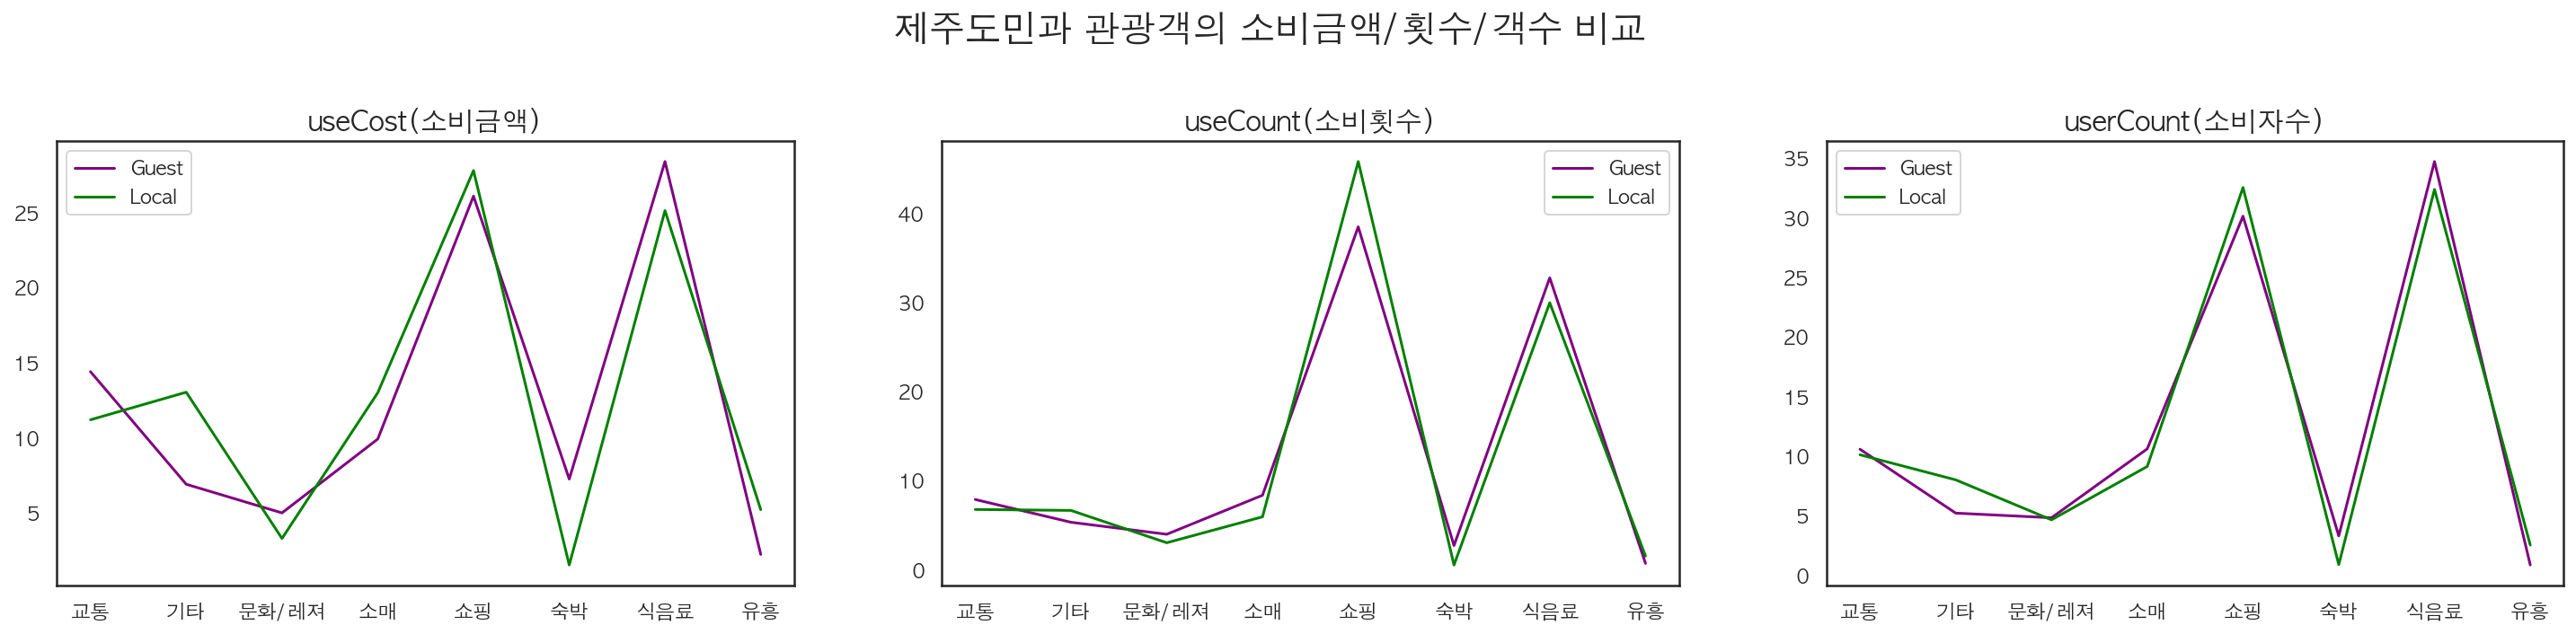

In [9]:
total_rate = pd.concat([guest_rate, local_rate], axis=1)
total_rate.sort_values(by='local_rate_useCost', ascending=False) # 정렬

plt.figure(figsize=(25,10))
cols = int(len(total_rate.columns)/2)
line_labels = ['Guest', 'Local']
plt_titles = ['useCost(소비금액)', 'useCount(소비횟수)', 'userCount(소비자수)']

for i in range(cols):
    plt.subplot(2,3,i+1)
    plt.suptitle("제주도민과 관광객의 소비금액/횟수/객수 비교", fontsize= 20)
    plt.plot(total_rate.index[:], total_rate[total_rate.columns[i]], color='purple')
    plt.plot(total_rate.index[:], total_rate[total_rate.columns[i+3]], color='green')
    plt.title(plt_titles[i], fontsize=15)
    plt.legend(labels=line_labels)

plt.show()

### [본론] ① 제주도 거주민 - 고소득층 밀집 지역 탐색
- 소득과 소비력에 직결되는 요소로서 '직업' 선정
- 직업(대기업,중소기업,공기업,전문직,자영업) 비중 <br>
  => [job_points] column 추가:직업군별 가중치(연봉 기준) 반영한 지표 생성 <br>
  => [job_level] column 추가:job_points 상위 1%, 4분위수 기준 5등급 구분

#### H2: 제주도민의 직업과 소득/소비는 상관관계가 있을 것이다
> med_income(0.6), avg_spend(0.5), avg_debt_credit(0.5), vehicle_own_rat(0.4) 과 양의 상관관계 <br> <br>
> <b> 결론 <br>
> ▶ 직업과 소득/소비는 상당한 상관관계가 있다.</b>

In [36]:
# raw 데이터 전처리
PATH = '../../datas/'
# 파일 불러오기
data = pd.read_csv(PATH + "jeju_financial_life_data.csv")
data.tail()

zip_cd  year_month      x_axis     y_axis  sex  age  job_majorc  \
10417   63268      201902  126.531404  33.509626    1   39    0.017544   
10418   63343      201902  126.665089  33.501399    1   59    0.028571   
10419   63072      201902  126.426763  33.485506    2   44    0.029412   
10420   63343      201902  126.665089  33.501399    1   64    0.052632   
10421   63343      201902  126.665089  33.501399    2   39    0.081081   

       job_smallc  job_public  job_profession  ...   avg_debt  \
10417    0.385965    0.035088        0.017544  ...   51576038   
10418    0.085714    0.085714        0.000000  ...  207666185   
10419    0.264706    0.000000        0.029412  ...   53861994   
10420    0.078947    0.052632        0.000000  ...  158266839   
10421    0.324324    0.054054        0.000000  ...   68784573   

       avg_debt_credit  avg_debt_noneb  avg_debt_mortgage  avg_debt_deposit  \
10417         23110274        13431142           89315216                 0   
10418         42386142        22437308          184612481          13600000   
10419         16967315        37701875           90772396            100000   
10420         34091265        28895365          186087107                 0   
10421         35872873        59023088          120188650                 0   

       avg_debt_collateral  avg_credit_rat  medium_resid_rat  large_resid_rat  \
10417            107706758               4         -999999.0        -999999.0   
10418            250278827               3         -999999.0        -999999.0   
10419            112076182               4         -999999.0        -999999.0   
10420            194598568               3         -999999.0        -999999.0   
10421            120188650               3         -999999.0        -999999.0   

       vehicle_own_rat  
10417         0.050000  
10418         0.052632  
10419         0.114286  
10420         0.048780  
10421         0.076923  

[5 rows x 27 columns]

In [37]:
# 1. 신용등급 > 신용점수 치환 : 나이스 신용정보 기준 해당 등급 최고점 반영
credit_points = {'avg_credit_rat':[2,3,4,5,6,7],
                'credit_points':[899,869,839,804,749,664]}
credit_table = pd.DataFrame(credit_points)
data['avg_credit_rat'].replace(credit_points['avg_credit_rat'],credit_points['credit_points'],inplace=True)
data[['avg_credit_rat']].head()

avg_credit_rat
0             804
1             839
2             899
3             839
4             804

In [38]:
# 2. job_points 컬럼 추가 : 직업군별 가중치(연봉 기준) 반영
# 직업군별 점수 가중치 환산 로직: '사업체 규모별 평균 임금' 통계자료 참조
# 대기업(100), 중소기업(68), 공기업(92), 전문직(100), 자영업(60), 무직(0), 기타(50)

job_df = data[['job_majorc','job_smallc','job_public','job_profession','job_self','job_none','job_other']]
job_points = [100, 68, 92, 100, 60, 0, 50]

# 가중치 점수 변환
sum_list = []
for a in range(0, len(job_df)):
    row_sum = 0
    for i in range(0,7):
        row_sum += job_df.loc[a][i]*job_points[i]
    sum_list.append(round(row_sum,2))
    
# job_points 컬럼 추가
job_df['job_points'] = sum_list

# 상세 직업군 drop 후 job_points 컬럼으로 대체job_points 컬럼으로 대체
data['job_points'] = sum_list
data_sample_1 = data.drop(['year_month','job_majorc','job_smallc','job_public','job_profession','job_self','job_none','job_other'], axis=1)

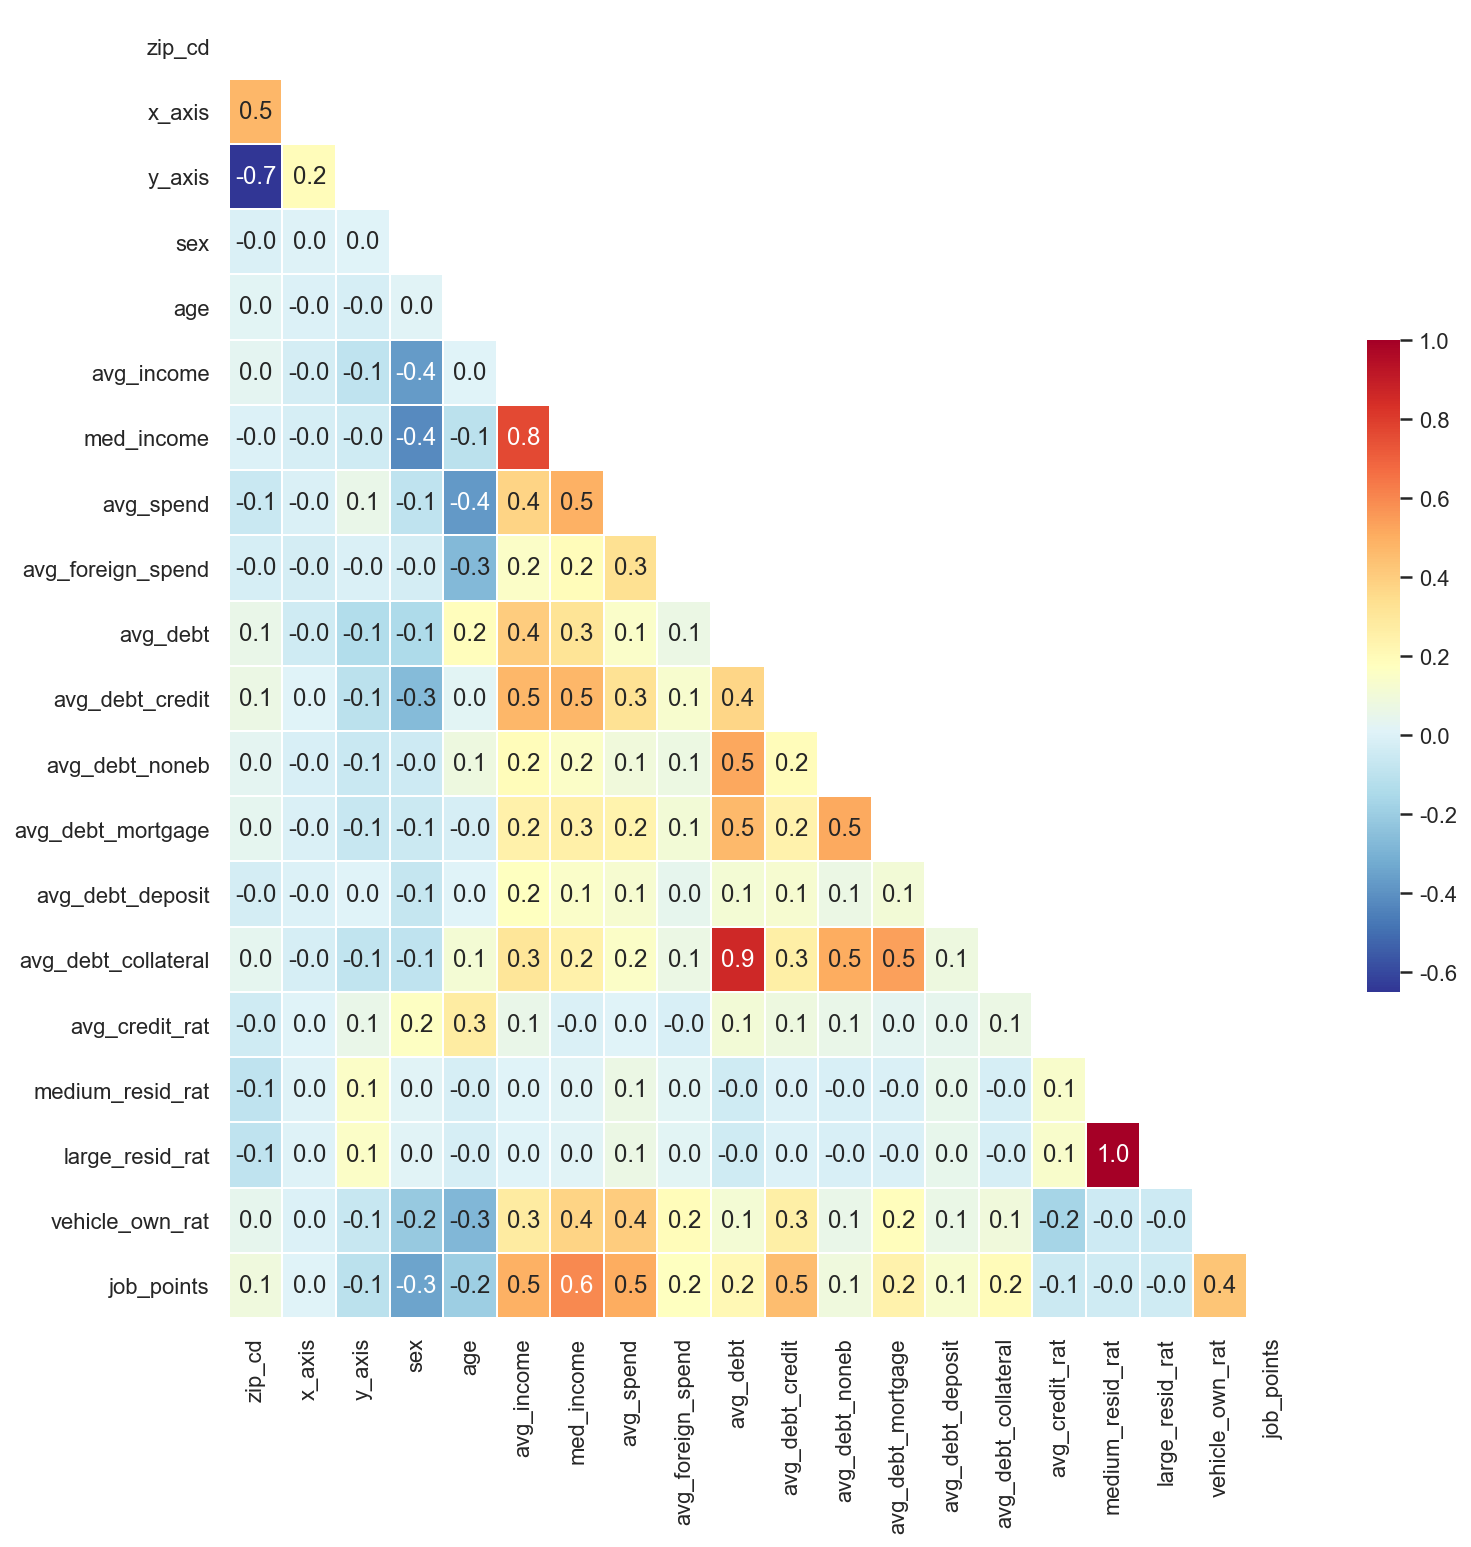

In [43]:
# 3. 요소별 상관관계 히트맵
plt.figure(figsize=(12,12))

mask = np.zeros_like(data_sample_1.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style("whitegrid")
a = sns.heatmap(data_sample_1.corr(), annot = True, fmt ='.1f', linewidths=0.5, cmap='RdYlBu_r',mask=mask, cbar_kws={'shrink':.5});

#### H3-1: 고소득/고소비 제주도민의 거주지는 밀집되어 있을 것이다
> <b> 결론 <br>
> ▶ 고소득/고소비 제주도민의 거주지는 밀집되어 있는 경향이 있다.</b>

In [44]:
# 4. job level 컬럼 추가 
# 직업은 소비력과 상관관계가 높다
# job points가 상위 1프로의 거주지가 밀집된 곳을 찾아보자
original = pd.read_csv(PATH + "jeju_financial_life_data.csv")
data = original.drop(['job_none','job_other'],axis=1).copy()
job_df = data[['job_majorc','job_smallc','job_public','job_profession','job_self']].copy()

# 무직, 기타 컬럼 drop 후 비중 재반영
job_majorc = []
job_smallc = []
job_public = []
job_profession = []
job_self = []

for a in range(0, len(original)):
    row_sum = 0
    for i in range(0,5):
        row_sum += job_df.loc[a][i]
        
    if row_sum == 0:
        job_majorc.append(0.0)
        job_smallc.append(0.0)
        job_public.append(0.0)
        job_profession.append(0.0)
        job_self.append(0.0)
    else:
        job_majorc.append(job_df.loc[a][0]/row_sum)
        job_smallc.append(job_df.loc[a][1]/row_sum)
        job_public.append(job_df.loc[a][2]/row_sum)
        job_profession.append(job_df.loc[a][3]/row_sum)
        job_self.append(job_df.loc[a][4]/row_sum)
        
job_df['job_majorc']=job_majorc
job_df['job_smallc']=job_smallc
job_df['job_public']=job_public
job_df['job_profession']=job_profession
job_df['job_self']=job_self

# job_points 컬럼 추가: 직업군별 가중치
# job_points = [100, 68, 92, 100, 60]
job_points = [100, 68, 92, 100, 60]
sum_list = []
for a in range(0, len(original)):
    row_sum = 0
    for i in range(0,5):
        row_sum += job_df.loc[a][i]*job_points[i]
    sum_list.append(round(row_sum,2))

data['job_points'] = sum_list

# 무직과 기타만 있던 행 삭제
drop_zero = data[data['job_points']==0].index
data = data.drop(drop_zero)

# job points를 기준으로 총 5개의 level로 분리
# 상위 1% (a등급), 4분위수 기준으로 나머지 4개 등급 분리(b~e등급)
job_level = []
level = ['e','d', 'c', 'b', 'a']
q = [0.25, 0.5, 0.75, 0.99, 1]

for i in range(0, len(original)):
    for index in range(0, 5):
        try:
            if data['job_points'].loc[i] <= data['job_points'].quantile(q[index]):
                job_level.append(level[index])
                break
        except KeyError:
            pass
        
# data 데이터 프레임에 job level 컬럼 추가
data['job_level'] = job_level

In [47]:
# a 등급만의 데이터 가져오기
jeju_a_lv = data[data['job_level']=='a']

# a 등급 지도에 표시
scatter_a = px.scatter(jeju_a_lv, x = "x_axis", y = "y_axis", size='job_points', size_max = 10)
scatter_a.show()

### [본론] ② 제주도 관광객 - 고급 호텔 밀집 지역 탐색
- 고소비층이 묵는 고급 호텔은 특정 지역에 밀집되어 있을 것이다 <br>
- 숙박업 결제 데이터 및 부킹닷컴 제주도 호텔 크롤링 데이터 사용

#### H3-2: 고소득/고소비 관광객이 묵는 숙박업소는 밀집되어 있을 것이다
> <b> 결론 <br>
> ▶ 고소득/고소비 관광객이 묵는 숙박업소는 밀집되어 있는 경향이 있다.</b>

In [30]:
# 부킹닷컴 호텔 크롤링 데이터 중 4,5성급 호텔
scraping_data_url = PATH + 'jeju_hotel_pivot.csv'
scraping_data = pd.read_csv(scraping_data_url, sep=',')
scraping_data.tail(2)

name  num  avg_star   avg_grade   avg_basePrice   \
518        휴 안 스테이    2       3.0          9.0         40,824    
519  히든 클리프 호텔&네이쳐    1       5.0          8.0        440,267    

     avg_currentPrice    avg_good review    avg_bad review   \
518                NaN                2.0               2.0   
519           286,000                 1.0               1.0   

                    addr              kor_addr   
518  서귀포, 성산읍 성산중앙로37번길 9  서귀포, 성산읍 성산중앙로37번길 9  
519        서귀포, 예래해안로 550        서귀포, 예래해안로 550

In [31]:
# 제주 내 호텔 소비 데이터
hotel_data_url = PATH + 'detailed_consume_type_data_hotel.csv'
datas = pd.read_csv(hotel_data_url, sep=',')

# Type = '콘도' 제외
datas = datas.iloc()[:,3:].reset_index(drop=True)
drop_rows = datas.index[datas['Type'] == '콘도'].tolist()
hotel_datas = datas.drop(index=drop_rows)
hotel_datas.tail(2)

# type = '기타숙박업' 제외
drop_rows = hotel_datas.index[hotel_datas['Type'] == '기타숙박업'].tolist()
drop_etc_accomodation = hotel_datas.drop(index=drop_rows)
drop_etc_accomodation.reset_index(inplace=True)
drop_etc_accomodation = drop_etc_accomodation.drop('index', axis=1)
drop_etc_accomodation.tail(3)

Sigungu FranClass  Type Time  TotalSpent  DisSpent  NumofSpent  \
539     제주시        일반  특급호텔   x시      300000         0           2   
540     제주시        일반  특급호텔   x시       12600         0           2   
541    서귀포시        일반  특급호텔   x시       39000         0           1   

     NumofDisSpent      POINT_X      POINT_Y LargeCategory MediumCategory  \
539              0  908678.9024  1503357.462           숙박업            호텔업   
540              0  909535.2455  1501962.168           숙박업            호텔업   
541              0  914371.1918  1473147.432           숙박업            호텔업   

         Proj_X     Proj_Y  
539  126.514514  33.520999  
540  126.523875  33.508489  
541  126.578676  33.249018

In [53]:
KEY_PATH = '../../keys/'

# api key 호출
def get_secretKeys():
    file = open(KEY_PATH + 'secret_keys.txt', 'rt')
    split_keys = []
    line_count = 0
    
    load_datas = file.readlines()
    
    file.close()
    
    for i in range(len(load_datas)):
        split_keys.append(load_datas[i].split('=')[1].replace('"', ""))
    
    return split_keys


def get_search_url(addr):
    api_keys = get_secretKeys()
    
    base = 'https://dapi.kakao.com/v2/local/search/address.json'
    header_phrase = 'KakaoAK'
    api_key = api_keys[1]
    
    headers = {'Authorization': header_phrase + api_key[1:]}
    req_param = '?query=' + str(addr)
    url = base + req_param
    
    return url, headers


# api 요청 응답
def get_result(url, headers):
    req = requests.get(url, headers=headers)
    res = json.loads(req.text)
    
    return res


# 응답 데이터 파싱
def json_parsing(res):
    res_dict = res['documents']
    x = res_dict[0]['x']
    y = res_dict[0]['y']
    
    return x, y


# 호텔 주소 데이터 위도 경도 변환 수행
addr_col = scraping_data.iloc()[:, -1:]
addr_list = [addr_col.loc()[i].tolist() for i in range(len(scraping_data))]

lat, lng = [], []

for i in range(len(addr_list)):
    target = addr_list[i]
    url, headers = get_search_url(target)
    res = get_result(url, headers)
    x, y = json_parsing(res)
    lat.append(x)
    lng.append(y)

#     try:
#         x, y = json_parsing(res)
#         lat.append(x)
#         lng.append(y)
        
#     except:
#         lat.append(0)
#         lng.append(0)

IndexError: list index out of range

In [14]:
lat = pd.DataFrame(columns=['x'], data=lat)
lng = pd.DataFrame(columns=['y'], data=lng)

# drop 0
drop_lat_list = lat.index[lat['x'] == 0.0].tolist()
drop_lat_zero = lat.drop(index=drop_lat_list)
drop_lat_zero.reset_index(drop=True, inplace=True)

drop_lng_list = lng.index[lng['y'] == 0.0].tolist()
drop_lng_zero = lng.drop(index=drop_lng_list)
drop_lng_zero.reset_index(drop=True, inplace=True)

lat = [drop_lat_zero.loc()[i][0] for i in range(len(drop_lat_zero))]
lng = [drop_lng_zero.loc()[i][0] for i in range(len(drop_lng_zero))]

rd_lat = [round(float(lat[i]), 6) for i in range(len(lat))]
rd_lng = [round(float(lng[i]), 6) for i in range(len(lng))]

type(rd_lat), type(rd_lng)

lat_df = pd.DataFrame(columns=['x'], data=rd_lat)
lng_df = pd.DataFrame(columns=['y'], data=rd_lng)

# 실제 4,5성급 호텔과 제주 내 호텔 업종 소비 결제 데이터를 합친 데이터
merged_hotel = pd.concat([scraping_data, lat_df, lng_df], axis=1)
merged_hotel.tail(2)           

name  num  avg_star   avg_grade   avg_basePrice   \
518        휴 안 스테이    2       3.0          9.0         40,824    
519  히든 클리프 호텔&네이쳐    1       5.0          8.0        440,267    

     avg_currentPrice    avg_good review    avg_bad review   \
518                NaN                2.0               2.0   
519           286,000                 1.0               1.0   

                    addr              kor_addr    x   y  
518  서귀포, 성산읍 성산중앙로37번길 9  서귀포, 성산읍 성산중앙로37번길 9 NaN NaN  
519        서귀포, 예래해안로 550        서귀포, 예래해안로 550 NaN NaN

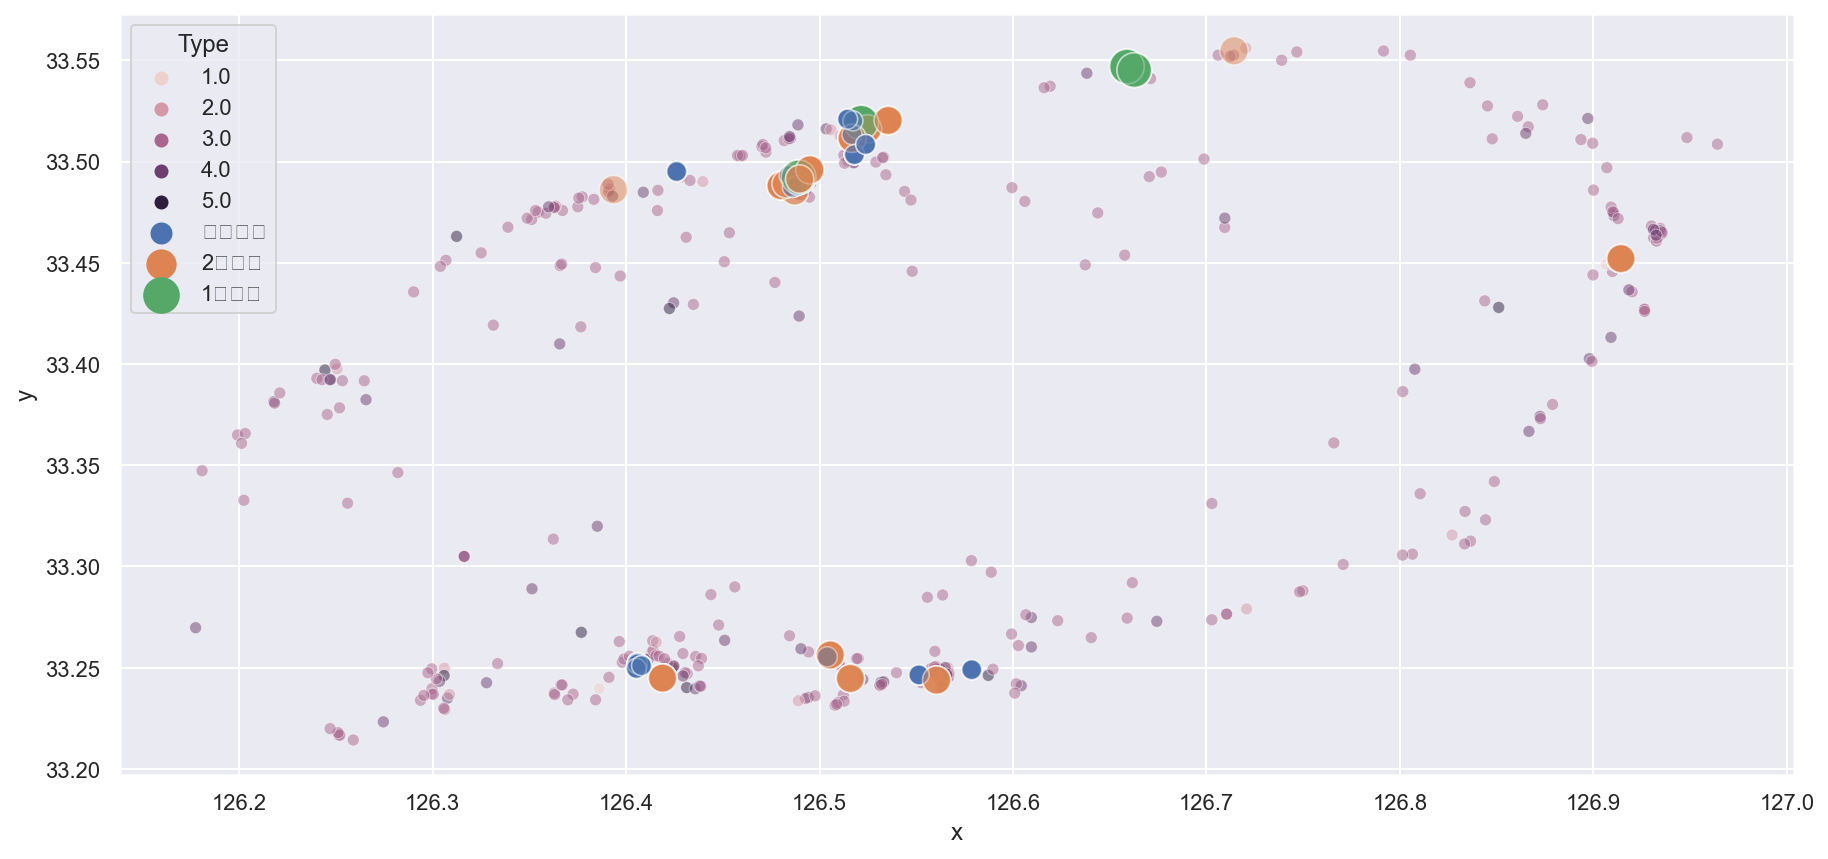

In [33]:
# 실제 제주내 호텔 분포와 관광객&내국인의 호텔 소비를 겹친 scatterplot
sns.set(rc={'figure.figsize':(15,7),'axes.unicode_minus':False}, style='darkgrid') # font='AppleGothic'
sns.scatterplot(x='x', y='y', hue='avg_star', data=merged_hotel, alpha=0.5);
sns.scatterplot('Proj_X', 'Proj_Y', data=drop_etc_accomodation, hue='Type', alpha=0.5, size='Type', sizes=(300,100));

### [결론]
- 본론 ①과 ② 교집합의 상위 동을 추려 8개 지역(읍/면/동 단위) 선정
- CHAPTER 2 에서 해당 지역에서 유망한 업종을 탐색해보고자 함

####  H3: 고소득/고소비층 소비자의 활동 영역은 밀집되어 있을 것이다
> <b> 결론 <br>
> ▶ 타켓 제주도민/관광객 거주지 및 숙박업소는 밀집되어 있는 경향이 있다.</b>

In [49]:
# a 등급만의 데이터 가져오기
jeju_a_lv = jeju_a_lv[['x_axis','y_axis']]
jeju_a_lv['name'] = 'a'
jeju_a_lv.reset_index(inplace=True, drop=True)
jeju_a_lv.rename(columns={'x_axis':'x', 'y_axis':'y'}, inplace=True)

# 1,2,3 성급을 제외한 실제 4,5 성급 호텔
options = [4.0, 5.0]

jeju_hotel45 = pd.DataFrame(merged_hotel, columns=merged_hotel.columns)
jeju_hotel45 = merged_hotel[merged_hotel['avg_star'].isin(options)]
jeju_hotel45.dropna()
jeju_hotel45 = jeju_hotel45.iloc[:, -2:]
jeju_hotel45['name'] = 'b'

In [50]:
# Merge: jeju_a_lv & jeju_hotel45
merge_df = pd.concat([jeju_a_lv, jeju_hotel45], axis=0)
merge_df.reset_index(inplace=True, drop=True)
merge_df.head()

x          y name
0  126.554738  33.501845    a
1  126.546748  33.508162    a
2  126.521242  33.505113    a
3  126.546112  33.514340    a
4  126.546112  33.514340    a

In [51]:
# 변환된 위도,경도를 주소로 요청
def reverse_geocoding(req_x, req_y):

    req_set = get_search_url(req_x, req_y)
    res_api = get_result(req_set[0], req_set[1])
    
    return res_api


# reverse geocoding start
proj_x = [merge_df['x'].tolist()]
proj_y = [merge_df['y'].tolist()]

res_json = []

for i in range(len(proj_x[0])):
    try:
        raw_res_json = reverse_geocoding(proj_x[0][i], proj_y[0][i])
        res_json.append(raw_res_json['documents'][0]['region_3depth_name'])
    except:
        res_json.append('')

        
merge_df['Dong'] = res_json
merge_df.head()

x          y name Dong
0  126.554738  33.501845    a     
1  126.546748  33.508162    a     
2  126.521242  33.505113    a     
3  126.546112  33.514340    a     
4  126.546112  33.514340    a

In [22]:
# a+b 상위 동
dong_count = merge_df.groupby(['Dong']).count()
top8 = dong_count.iloc[:,-1:].sort_values(by='name', ascending=False)[:8]
top8.rename(columns={'name':'count'}, inplace=True)
top8 = top8.reset_index()
top8

Dong  count
0         191

<div class="alert alert-block" style="border: 1px solid #FFB300;background-color:#F9FBE7;">
<font size="3em" style="font-weight:bold;color:#3f8dbf;">CHAPTER 2) 제주도 유망 사업 업종 분석</font><br><br>
- CHAPTER 1에서 선정한 고소비층 밀집 지역 기준, 유망한 업종 탐색 <br>
- 신규 개인 창업을 가정으로 아래 기준의 데이터 활용하여 분석 진행 <br>
    ※ 영세 상점의 실 결제 데이터 사용 / 제주시 내 10시 ~ 22시 사이 결제 / '소매업', '음식점업' 한정 <br>
- Folium 지도 시각화를 통한 지역별/업종별 비교
 </div>

### [서론] WHERE 어느 지역에서?
- 본론 ①과 ② 교집합의 상위 동을 추려 8개 지역(읍/면/동 단위) 선정
- 성산읍, 남원읍, 애월읍, 연동, 한림읍, 안덕면, 이도이동, 조천읍
<div>
<img src="img/jeju_ppt/ppt5.jpg", width='700'/></div>

In [45]:
emd = gpd.read_file(PATH + '/EMD_202101/TL_SCCO_EMD.shp', encoding='euc-kr')
jeju_emd = emd.loc[(emd['EMD_CD'].str.startswith('5011')|emd['EMD_CD'].str.startswith('5013'))]
jeju_emd['geometry'] = jeju_emd['geometry'].to_crs('EPSG:4326')

# CHAPTER 1 선정 지역
df = pd.DataFrame({'emd':['성산읍', '남원읍', '애월읍', '연동', '한림읍', '안덕면', '이도이동', '조천읍'],
                 'no':[16,14,14,11,10,8,8,8]})

# folium map 그리기
f = folium.Figure(width=600, height=400)

# 제주공항을 기점으로 제주도 지도 표시
m = folium.Map(location = [33.363, 126.533],
               zoom_start= 10)

# 선정 지역, 언급 횟수를 기준으로 표시
folium.Choropleth(
            geo_data=jeju_emd, 
            data = df,
            key_on = 'feature.properties.EMD_KOR_NM',
            columns = ('emd','no'),
            fill_color = 'OrRd',
            fill_opacity=0.6,
            line_opacity=1,
            overlays = True,
            highlight=True
         ).add_to(m)

m

### [본론] WHAT 어떤 업종을?
- 경제력이 있는 소비자층의 밀집된 지역에서 <b> 매출액이 높은 업종 탐구 </b><br>
- 영세 상점 / 10~23시 / 소매업+음식점업